<a href="https://colab.research.google.com/github/dinggga/super-broccoli/blob/main/220627hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[개념정리]**
## **06. 객체 탐지(Object Detection)**
- 입력 이미지로부터 여러 개의 객체 찾아내고 네모 박스 그림(Regression) + 각 개체가 무엇을 하는지 분류(Classification)
  - 네모 박스 경계 나타내는 좌표값을 회귀 문제로 접근

### **6.1 텐서플로 허브 활용**
- 다양한 딥러닝 문제를 해결할 수 있는 검증된 사전 학습(pre-trained) 모델을 제공하는 저장소
- 텐서플로 허브에서 제공하는 객체 탐지 모델 사용하여 샘플 이미지로부터 객체 추출하는 작업 할 것

**6.1.1 샘플 이미지 준비**

**6.1.2 사전 학습 모델**
- Open Images v4 데이터셋의 inception_resnet_v2 모델 사용(Faster R-CNN 알고리즘으로 구현)

**6.1.3 추론**
- 추론 거쳐 예측값 반환.

## **6.2 YOLO 객체 탐지**
- 경계 박스와 예측 클래스 둘 다 하나의 회귀 문제로 접근하는 개념. 하나의 신경망이 한 번만 계산해 두 가지 일을 한꺼번에 처리하므로 속도가 매우 빠름.

### **6.2.1 Darknet YOLO 모델 추론하기**
- 깃허브 저장소 다운 > GPU 사용 가능하도록 Darknet의 Makefile 수정, Darknet 생성 > Darknet 실행해 탐지

### **6.2.2 나만의 YOLO 모델 생성**
- 검은색 바탕에 간단한 도형 3개를 탐지하는 YOLO 모델 생성
- cv2를 이용하여 랜덤한 위치에 3개의 도형 이미지 그림
- 해당 이미지 위치 찾아 경계 박스로 나타내고 정답 클래스 레이블까지 반환되는 함수 정의
- 전이학습 방법 적용하여 VGG16 모델 베이스로 사용하고, Conv2D층과 Dense레이어를 마지막 객체 탐지 분류기로 설정
- 이미지를 (3x3)셀로 나누고 셀마다 학습 진행



## **07. 이미지 분할(Segmentation)**
- 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류. 모든 픽셀은 어떤 클래스에 속함
- 의미분할(semantic segmentation) / 인스턴스 분할(instance segmentation)으로 구분
- 의미 분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
- 인스턴스 분할: 같은 범주에 속하더라도 서로 다른 객체를 구분

### **7.1 데이터셋 준비**
- 데이터셋: Oxford-IIIT Pet Dataset (반려동물 이미지 및 분류 ㅔ이블, 각 이미지를 구성하는 픽셀 단위의 마스크-class 1, 2, 3)
- 이미지, 마스크 전처리 함수 생성
- 미니배치로 분할
- 샘플 배치 선택
- 마스크 이미지 출력

### **7.2 U-Net 모델(인코더-디코더)**
- 사전학습된 VGG16 모델을 인코더로 활용
- 인코더: 원본 이미지 중 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소
- 만드려는 U-net 모양 미리 정하고, 출력할 shape를 정함
- 업샘플링: 축소된 이미지를 원래 이미지 크기로 복원하는 과정. 인코더의 출력을 디코더의 입력으로 전달하는 과정에서 수행.
- Unet 모델 시각화, 요약




---
---
# **[필사]**

6.1 텐서플로 허브 활용

In [9]:
import tensorflow as tf
import tensorflow_hub as tfhub

6.1.1 샘플 이미지 준비

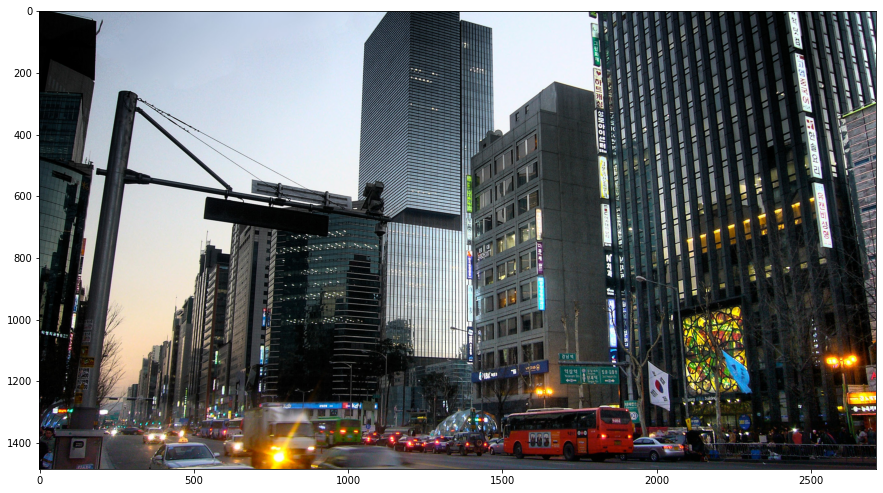

In [10]:
# 샘플 이미지 다운로드
img_path = 'https://upload.wikimedia.org/wikipedia/commons/c/c4/Gangnam_Seoul_January_2009.jpg'
img = tf.keras.utils.get_file(fname='gangnam', origin=img_path)
img = tf.io.read_file(img)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)

import matplotlib.pylab as plt
plt.figure(figsize=(15,10))
plt.imshow(img)

In [11]:
img_input = tf.expand_dims(img, 0)
img_input.shape

TensorShape([1, 1484, 2713, 3])

6.1.2 사전 학습 모델


In [12]:
model= tfhub.load('https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7FD73341E290>}))

In [18]:
obj_detector = model.signatures['default']
obj_detector

<ConcreteFunction pruned(images) at 0x7FD73341E290>

6.1.3 추론

In [19]:
result = obj_detector(img_input)
result.keys()

dict_keys(['detection_class_labels', 'detection_class_names', 'detection_scores', 'detection_boxes', 'detection_class_entities'])

In [20]:
# 탐지한 객체 개수
len(result['detection_scores'])

100

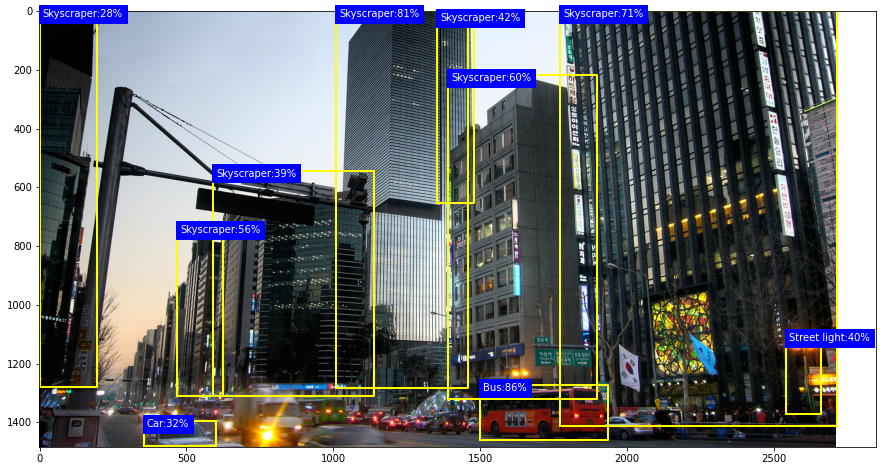

In [23]:
# 객체 탐지 결과를 시각화
boxes = result['detection_boxes']
labels = result['detection_class_entities']
scores = result['detection_scores']

# 샘플 이미지 가로 세로 크기
img_height, img_width = img.shape[0], img.shape[1]

# 탐지할 최대 객체의 수
obj_to_detect = 10

# 시각화
plt.figure(figsize=(15,10))
for i in range(min(obj_to_detect, boxes.shape[0])):
  if scores[i]>=0.2:
    (ymax, xmin, ymin, xmax) = (boxes[i][0] * img_height, boxes[i][1] * img_width,
                                boxes[i][2] * img_height, boxes[i][3] * img_width)
    plt.imshow(img)
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='yellow', linewidth=2)
    
    class_name = labels[i].numpy().decode('utf-8')
    infer_score = int(scores[i].numpy()*100)
    annotation = '{}:{}%'.format(class_name, infer_score)
    plt.text(xmin+10, ymax+20, annotation, color='white', backgroundcolor='blue', fontsize=10)

6-2 YOLO 객체 탐지

In [24]:
# 깃허브 저장소 복제
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 15424 (delta 0), reused 1 (delta 0), pack-reused 15423
Receiving objects: 100% (15424/15424), 14.05 MiB | 11.99 MiB/s, done.
Resolving deltas: 100% (10364/10364), done.


In [25]:
# GPU 활성화
%cd darknet
!sed -i's/GPU=0/GPU=1/'Makefile
!sed -i's/CUDNN=0/CUDNN=1/'Makefile
!sed -i's/CUDNN_HALF=0/CUDNN_HALF=1/'Makefile

/content/darknet
Usage: sed [OPTION]... {script-only-if-no-other-script} [input-file]...

  -n, --quiet, --silent
                 suppress automatic printing of pattern space
  -e script, --expression=script
                 add the script to the commands to be executed
  -f script-file, --file=script-file
                 add the contents of script-file to the commands to be executed
  --follow-symlinks
                 follow symlinks when processing in place
  -i[SUFFIX], --in-place[=SUFFIX]
                 edit files in place (makes backup if SUFFIX supplied)
  -l N, --line-length=N
                 specify the desired line-wrap length for the `l' command
  --posix
                 disable all GNU extensions.
  -E, -r, --regexp-extended
                 use extended regular expressions in the script
                 (for portability use POSIX -E).
  -s, --separate
                 consider files as separate rather than as a single,
                 continuous long stream.
      -

In [26]:
# Darknet 생성
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -c ./src/image_opencv.cpp -o obj/image_opencv.o
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sender::write(const char*)’:
./src/http_stream.cpp:253:21: warning: unused variable ‘n’ [-Wunused-variable]
                 int n = _write(client, outputbuf, outlen);
                     ^
./src/http_stream.cpp: In function ‘void set_track_id(detection*, int, float, float, float, int, int, int)’:
./src/http_stream.cpp:867:27: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
         for (int i = 0; i < v.size(); ++i) {
                         ~~^~~~~~~~~~
./src/http_stream.cpp:875:33: warning: c

In [27]:
# 모델 가중치 가져오기
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_b3_optimal/yolov4.weights

--2022-06-27 06:59:42--  https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_b3_optimal/yolov4.weights
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-27 06:59:43 ERROR 404: Not Found.



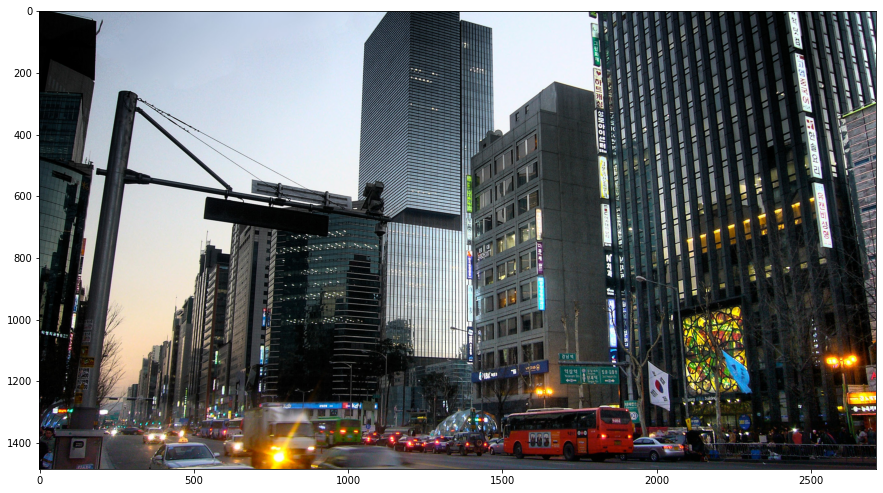

In [29]:
# 업로드한 샘플 이미지 출력해서 확인
plt.figure(figsize=(15,10))
img_path = 'https://upload.wikimedia.org/wikipedia/commons/c/c4/Gangnam_Seoul_January_2009.jpg'
img = tf.keras.utils.get_file(fname='gangnam', origin=img_path)
img = tf.io.read_file(img)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
plt.imshow(img)

In [31]:
# Darknet 실행
!./darknet detector test cfg/coco.data cfg/yolov4.cfg_yolo4.weights/https://upload.wikimedia.org/wikipedia/commons/c/c4/Gangnam_Seoul_January_2009.jpg

 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
Couldn't open file: cfg/yolov4.cfg_yolo4.weights/https://upload.wikimedia.org/wikipedia/commons/c/c4/Gangnam_Seoul_January_2009.jpg


In [ ]:
plt.figure(figsize=(15,10))
img = tf.io.read_file('/content/darknet/predictions/jpg')
img = tf.image.decode_jpeg(img, channel=3)


6.2.2 나만의 YOLO 모델 생성


In [32]:
# 필요한 패키지 임포트
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# 파라미터 설정
# 이미지 크기
width_size=256
hight_size=256
channel_size=3
img_size = (width_size, hight_size, channel_size)

# 이미지를 나눌 크기
cell_num = 3
# 찾고자 하는 객체 개수
class_num = 3
# 한 셀에 그릴 박스 수
anchor_num = 1
label_num = anchor_num * (5 + class_num)
# 학습 수
epoch_num = 20000
# 로스 비중
loss_p_rate = 1.0
loss_cod_rate = 5.0
loss_c_rate = 1.0
loss_p_no_rate = 5.0

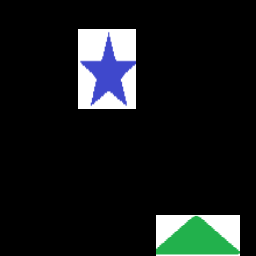

In [33]:
# 랜덤하게 도형을 그리고, 실제 정답 값을 생성하는 함수 정의
# 0.png / 1.png / 2.png 파일이 필요함

def make_img_label():
    img = np.zeros((hight_size+400,width_size+400,channel_size))
    label = np.zeros((cell_num,cell_num,label_num))
    num_shape = np.random.randint(1,4)
    i = np.random.choice(range(cell_num),num_shape,replace=False)
    j = np.random.choice(range(cell_num),num_shape,replace=False)
    
    img_0 = cv2.imread('/content/drive/MyDrive/ESAA_OB/220627M/0.png')
    img_1 = cv2.imread('/content/drive/MyDrive/ESAA_OB/220627M/1.png')
    img_2 = cv2.imread('/content/drive/MyDrive/ESAA_OB/220627M/2.png')
    
    for n_h in range(num_shape):
        row = i[n_h]
        col = j[n_h]
        
        shape_type = np.random.randint(0,class_num)
        x_rate = np.random.rand()
        y_rate = np.random.rand()
        w_rate = np.random.rand() * 0.3 +0.1
        h_rate = np.random.rand() * 0.3 +0.1
                
        label[row,col]=[1,x_rate,y_rate,w_rate,h_rate,0,0,0]
        label[row,col,5+shape_type]=1

        x = int(x_rate * width_size/cell_num + col * width_size/cell_num)
        y = int(y_rate * hight_size/cell_num + row * hight_size/cell_num)
        w = int(w_rate * width_size/2) * 2
        h = int(h_rate * hight_size/2) * 2

        if(shape_type==0):
            input_img = cv2.resize(img_0,(w,h))
        if(shape_type==1):
            input_img = cv2.resize(img_1,(w,h))
        if(shape_type==2):
            input_img = cv2.resize(img_2,(w,h))

        img[y-int(h/2)+200 : y+int(h/2)+200, x-int(w/2)+200 : x+int(w/2)+200] =input_img
    img = img[200:200+hight_size,200:200+width_size]        
    
    return img,label

img,label = make_img_label()
cv2_imshow(img)

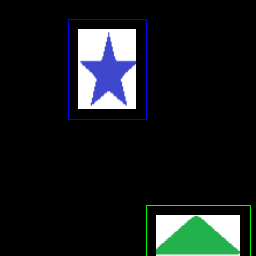

In [34]:
# 이미지와 정답(혹은 예측값)을 넣으면 박스를 그려주는 함수 정의
# 임계값 th 설정 (객체가 있다는 확률이 th이상일 때만 박스 생성)
def show_box(img,label,th=0.3):
    b_img = np.zeros((hight_size+400,width_size+400,3))
    b_img[200:200+hight_size,200:200+width_size] = img
    for i in range(cell_num):
        for j in range(cell_num):
            if(label[i,j,0] > th):
                x_rate = label[i,j,1]
                y_rate = label[i,j,2]
                w_rate = label[i,j,3]
                h_rate = label[i,j,4]
                shape_type=np.argmax(label[i,j,5:])
                if(shape_type==0):
                    line_color = [0,0,255]
                if(shape_type==1):
                    line_color = [255,0,0]
                if(shape_type==2):
                    line_color = [0,255,0]
                x = int(x_rate * width_size/3 + j * width_size/3)
                y = int(y_rate * hight_size/3 + i * hight_size/3)
                w = int(w_rate * width_size/2) * 2 + 20
                h = int(h_rate * hight_size/2) * 2 + 20

                cv2.rectangle(b_img,(x-int(w/2)+200,y-int(h/2)+200),(x+int(w/2)+200,y+int(h/2)+200),line_color)
                
    b_img = b_img[200:200+hight_size,200:200+width_size]

    return b_img

cv2_imshow(show_box(img,label))

In [35]:
# VGG16모델을 베이스로 마지막 부분만 수정하는 모델 생성 (전이 학습)
vgg_model = tf.keras.applications.VGG16(include_top=False,input_shape=img_size)
vgg_model.trainable=False

i=tf.keras.Input(shape=img_size)
out=tf.keras.layers.Lambda((lambda x : x/255.))(i)
out = vgg_model(out)
out = tf.keras.layers.Conv2D(256,3,padding='same')(out)
out = tf.keras.layers.Conv2D(128,3,padding='same')(out)
out = tf.keras.layers.Conv2D(64,3,padding='same')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(1024,activation='relu')(out)
out = tf.keras.layers.Dense(3*3*8,activation='sigmoid')(out)
out = tf.keras.layers.Reshape((3,3,8))(out)

yolo_model = tf.keras.Model(inputs=[i],outputs=[out])
opt = tf.keras.optimizers.Adam(0.00001)

# 모델 요약
yolo_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          73792     
                                                              

In [36]:
# 학습과정을 동영상으로 기록
fcc=cv2.VideoWriter_fourcc(*'DIVX')
out=cv2.VideoWriter('hjk_yolo.avi',fcc,1.0,(width_size,hight_size))


for e in range(epoch_num):
    img,label = make_img_label()
    img = np.reshape(img,(1,hight_size,width_size,3))
    label = np.reshape(label,(1,3,3,8))
    loss_p_list=[]
    loss_cod_list = []
    loss_c_list = []
    loss_p_no_list = []
    with tf.GradientTape() as tape:
        pred = yolo_model(img)
        # 이미지를 구분한 셀을 탐험
        for i in range(3):
            for j in range(3):
                # 해당 셀에 객체가 있을 경우는 확률, 박스 크기, 클래스까지 모두 Loss로 계산
                if(label[0,i,j,0]==1):
                    loss_p_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
                    loss_cod_list.append(tf.square(label[0,i,j,1]-pred[0,i,j,1]))
                    loss_cod_list.append(tf.square(label[0,i,j,2]-pred[0,i,j,2]))
                    loss_cod_list.append(tf.square(label[0,i,j,3]-pred[0,i,j,3]))
                    loss_cod_list.append(tf.square(label[0,i,j,4]-pred[0,i,j,4]))
                    loss_c_list.append(tf.square(label[0,i,j,5]-pred[0,i,j,5]))
                    loss_c_list.append(tf.square(label[0,i,j,6]-pred[0,i,j,6]))
                    loss_c_list.append(tf.square(label[0,i,j,7]-pred[0,i,j,7]))
                # 해당 셀에 객체가 없을 경우 객체가 없을 확률만 Loss로 계산
                else:
                    loss_p_no_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
        loss_p=tf.reduce_mean(loss_p_list)
        loss_cod =tf.reduce_mean(loss_cod_list)
        loss_c = tf.reduce_mean(loss_c_list)
        loss_p_no = tf.reduce_mean(loss_p_no_list)
        # 각 Loss를 비중을 곱해 더해 최종 Loss를 계산
        loss = loss_p_rate * loss_p + loss_cod_rate * loss_cod + loss_c_rate * loss_c + loss_p_no_rate * loss_p_no
    # Loss에 대한 Grad를 구하고, 각 파라미터를 업데이트
    vars = yolo_model.trainable_variables
    grad = tape.gradient(loss, vars)
    opt.apply_gradients(zip(grad, vars))
    # 100번 마다 동영상에 이미지를 기록한다
    if(e%100==0):
        img = np.reshape(img,(256,256,3))
        label = pred.numpy()
        label = np.reshape(label,(3,3,8))
        sample_img = np.uint8(show_box(img,label))
        out.write(sample_img)
    print(e,"완료",loss.numpy())    
out.release()

57 완료 1.3442049
58 완료 1.5068148
59 완료 0.9801923
60 완료 1.2108115
61 완료 1.2861675
62 완료 1.3211311
63 완료 1.1001613
64 완료 1.2357491
65 완료 1.4996438
66 완료 1.1587439
67 완료 1.1659027
68 완료 1.1329458
69 완료 1.5941188
70 완료 1.2197101
71 완료 1.3512491
72 완료 1.109112
73 완료 1.3558532
74 완료 1.2459011
75 완료 1.1874535
76 완료 1.0165114
77 완료 1.3166099
78 완료 1.0857627
79 완료 1.1202455
80 완료 1.3065244
81 완료 1.1588367
82 완료 1.1885719
83 완료 1.4381584
84 완료 1.2664634
85 완료 1.5504489
86 완료 1.1957226
87 완료 1.4970242
88 완료 1.4092766
89 완료 1.2957855
90 완료 1.0714533
91 완료 1.2778767
92 완료 1.4165817
93 완료 0.9072789
94 완료 1.2010138
95 완료 1.5275309
96 완료 0.9999009
97 완료 1.159397
98 완료 1.2060181
99 완료 1.1847813
100 완료 1.0455412
101 완료 1.1956066
102 완료 0.744341
103 완료 1.5069369
104 완료 1.2976902
105 완료 1.6917495
106 완료 1.6817893
107 완료 1.236896
108 완료 1.0049807
109 완료 1.3374817
110 완료 1.541029
111 완료 1.4826279
112 완료 0.841819
113 완료 1.290229
114 완료 1.2789552
115 완료 1.1845546
116 완료 1.192979
117 완료 1.3244998
118 완료 1.14112

KeyboardInterrupt: ignored

시간 관계상 생략

07. 이미지 분할(Segmentation)

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [38]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [39]:
# 텐서플로 데이터셋 로드 
ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteM7HSTW/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteM7HSTW/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [40]:
# 이미지 전처리 함수 
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크 
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask

In [41]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [42]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

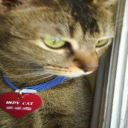

In [43]:
# 샘플 이미지 출력 
img = np.array(img[0])*255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

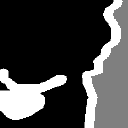

In [44]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

7.2 U-Net 모델(인코더-디코더)

In [45]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

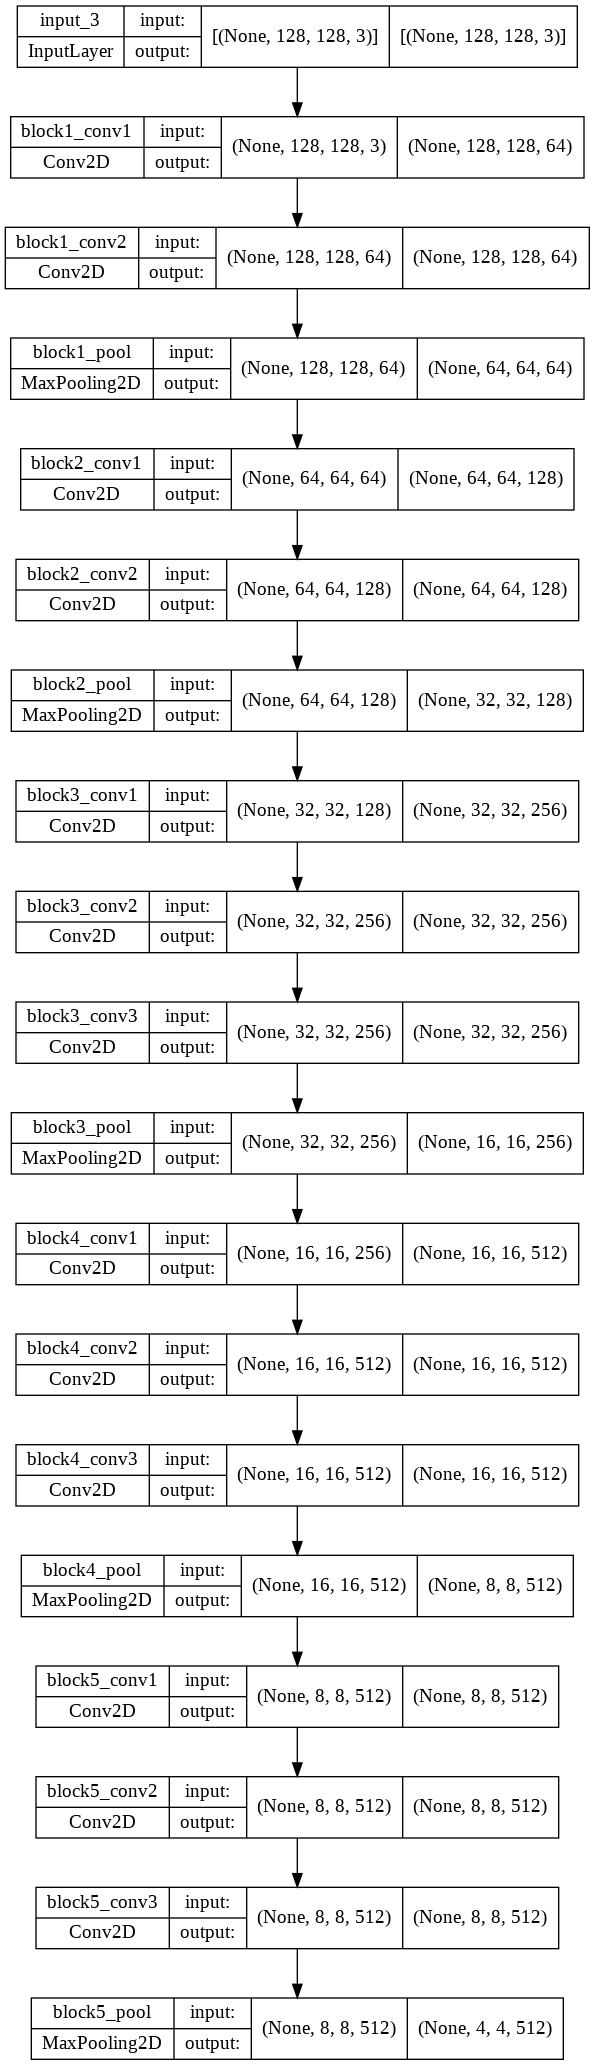

In [46]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

In [47]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

In [48]:
# 파라미터 고정
f_model.trainable = False

In [49]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

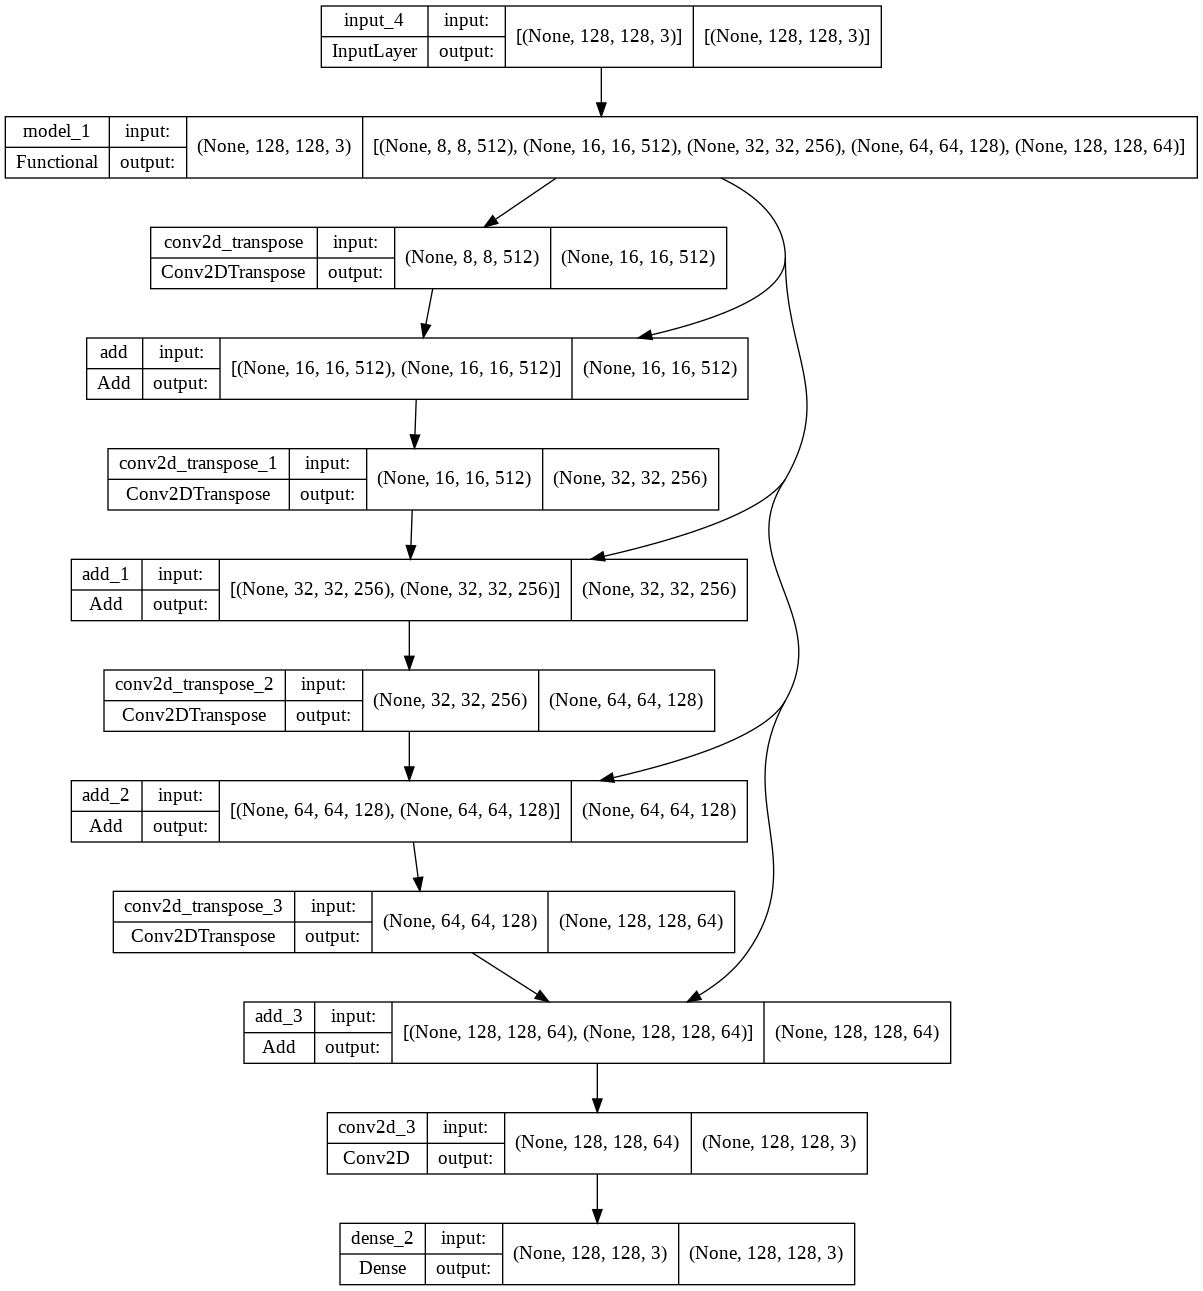

In [50]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [51]:
# 모델 요약
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           [(None, 8, 8, 512),  14714688    ['input_4[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [52]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1294s 6s/step - loss: 0.8827 - accuracy: 0.6826
Epoch 2/5
230/230 [==============================] - 1291s 6s/step - loss: 0.5736 - accuracy: 0.7889
Epoch 3/5
230/230 [==============================] - 1308s 6s/step - loss: 0.5331 - accuracy: 0.8031
Epoch 4/5
 49/230 [=====>........................] - ETA: 17:09 - loss: 0.5121 - accuracy: 0.8093

KeyboardInterrupt: ignored

시간 관계상 생략

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

In [ ]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))